In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import segmentation_models_pytorch as smp
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import warnings
from glob import glob
from PIL import Image,ImageFilter
from skimage.morphology import skeletonize,square,dilation 

from PVBM.GeometricalAnalysis import GeometricalVBMs
from PVBM.FractalAnalysis import MultifractalVBMs

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def imgshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.5023, 0.5017, 0.5019])
    # std = np.array([0.1245, 0.0934, 0.0581])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [3]:
img_size = (300,300)
batch_size = 14
model_name = 'densenet121'
learning_rate = 0.001
num_epochs=20
nm_model = f'models/{model_name}_vessel_e{num_epochs}_s{img_size[0]}_b{batch_size}'

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()        
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()        
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()        
    ])
}

data_dir = 'data/data_m_vessel'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

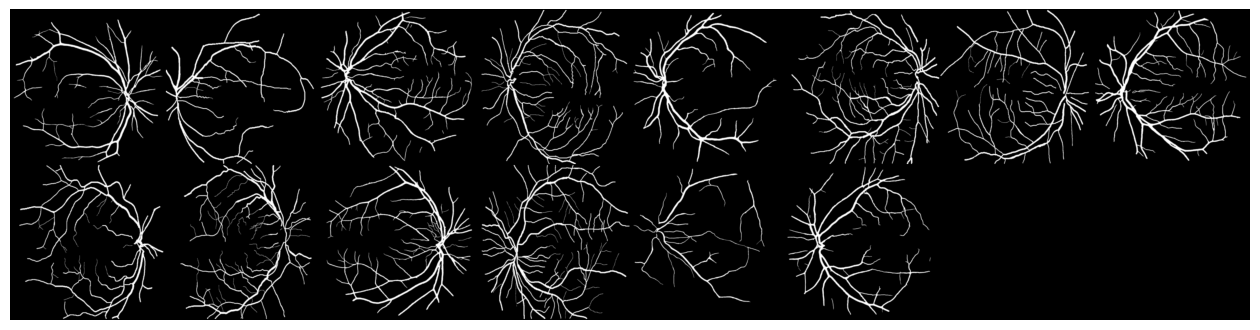

In [5]:
samples, labels = next(iter(dataloaders['train']))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples)
imgshow(grid_imgs)

In [6]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', model_name, pretrained=True)
num_ftrs = model_ft.classifier.in_features

model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  len(class_names)))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model_data = pd.DataFrame({'epoch number': [],
                               'train loss': [],
                               'validation loss': [],
                               'train f1_score': [],
                               'validation f1_score': [],
                               'train accuracy': [],
                               'validation accuracy': [],
                               'train recall': [],
                               'validation recall': [],
                               'train precision': [],
                               'validation precision': [],
                               'test loss':[],
                               'test f1_score':[],
                               'test accuracy':[],
                               'test recall':[],
                               'test precision':[]})

In [8]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        model_data.at[epoch, 'epoch number'] = epoch+1
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            metric_monitor = MetricMonitor()
            

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                
                    tn, fp, fn, tp = confusion_matrix(labels.cpu(), preds.cpu(), labels=[0, 1]).ravel()
                    
                    f1_score = (2*tp)/(2*tp+fp+fn)
                    accuracy = (tp+tn)/(tp+tn+fp+fn)
                    recall = (tp)/(tp+fn)
                    precision = (tp)/(tp+fp)
                    loss = criterion(outputs, labels)

                    metric_monitor.update("Loss", loss.item())
                    metric_monitor.update("f1 score", f1_score)
                    metric_monitor.update("accuracy", accuracy)
                    metric_monitor.update("recall", recall)
                    metric_monitor.update("precision", precision)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                torch.cuda.empty_cache() ####???????

            epoch_acc = metric_monitor.metrics['accuracy']['avg']

            if phase == 'train':
                scheduler.step()
                model_data.at[epoch, 'train loss'] = metric_monitor.metrics['Loss']['avg']
                model_data.at[epoch, 'train f1 score'] = metric_monitor.metrics['f1 score']['avg']
                model_data.at[epoch, 'train accuracy'] = metric_monitor.metrics['accuracy']['avg']
                model_data.at[epoch, 'train recall'] = metric_monitor.metrics['recall']['avg']
                model_data.at[epoch, 'train precision'] = metric_monitor.metrics['precision']['avg']
            else:
                model_data.at[epoch, 'validation loss'] = metric_monitor.metrics['Loss']['avg']
                model_data.at[epoch, 'validation f1 score'] = metric_monitor.metrics['f1 score']['avg']
                model_data.at[epoch, 'validation accuracy'] = metric_monitor.metrics['accuracy']['avg']
                model_data.at[epoch, 'validation recall'] = metric_monitor.metrics['recall']['avg']
                model_data.at[epoch, 'validation precision'] = metric_monitor.metrics['precision']['avg']

            print(f'{phase} {metric_monitor}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    model_data.to_csv(nm_model+'_stats.csv', index=False)

    return model

In [9]:
def test_model(model):    
    was_training = model.training
    model.eval()
    metric_monitor = MetricMonitor()

    for i, data in enumerate(dataloaders['test'], 0):
        samples, labels = data
        with torch.no_grad():
            
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            _, preds = torch.max(output, 1)
            tn, fp, fn, tp = confusion_matrix(labels.cpu(), preds.cpu(), labels=[0, 1]).ravel()
            
            f1_score = (2*tp)/(2*tp+fp+fn)
            accuracy = (tp+tn)/(tp+tn+fp+fn)
            recall = (tp)/(tp+fn)
            precision = (tp)/(tp+fp)
            
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("f1 score", f1_score)
            metric_monitor.update("accuracy", accuracy)
            metric_monitor.update("recall", recall)
            metric_monitor.update("precision", precision)

            torch.cuda.empty_cache()
            model.train(mode=was_training)

    model_data = pd.read_csv(nm_model+'_stats.csv')
    index = len(model_data.axes[0])
    model_data.at[index, 'test loss'] = metric_monitor.metrics['Loss']['avg']
    model_data.at[index, 'test f1 score'] = metric_monitor.metrics['f1 score']['avg']
    model_data.at[index, 'test accuracy'] = metric_monitor.metrics['accuracy']['avg']
    model_data.at[index, 'test recall'] = metric_monitor.metrics['recall']['avg']
    model_data.at[index, 'test precision'] = metric_monitor.metrics['precision']['avg']
    model_data.to_csv(nm_model+'_stats.csv', index=False)
    print('Testing {} %'.format(metric_monitor))


In [10]:
warnings.filterwarnings('ignore')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
test_model(model_ft)

Epoch [1/20]
train Loss: 0.668 | f1 score: 0.590 | accuracy: 0.662 | recall: 0.619 | precision: nan
val Loss: 1.139 | f1 score: 0.574 | accuracy: 0.643 | recall: 0.540 | precision: 0.681
Epoch [2/20]
train Loss: 0.570 | f1 score: 0.689 | accuracy: 0.708 | recall: 0.693 | precision: 0.765
val Loss: 0.633 | f1 score: 0.662 | accuracy: 0.664 | recall: 0.742 | precision: 0.635
Epoch [3/20]
train Loss: 0.554 | f1 score: 0.715 | accuracy: 0.736 | recall: 0.719 | precision: 0.786
val Loss: 4.899 | f1 score: 0.656 | accuracy: 0.493 | recall: 1.000 | precision: 0.493
Epoch [4/20]
train Loss: 0.508 | f1 score: 0.748 | accuracy: 0.759 | recall: 0.775 | precision: 0.789
val Loss: 1.871 | f1 score: 0.279 | accuracy: 0.586 | recall: 0.192 | precision: nan
Epoch [5/20]
train Loss: 0.499 | f1 score: 0.774 | accuracy: 0.784 | recall: 0.777 | precision: 0.807
val Loss: 0.954 | f1 score: 0.411 | accuracy: 0.614 | recall: 0.309 | precision: nan
Epoch [6/20]
train Loss: 0.488 | f1 score: 0.736 | accuracy: 

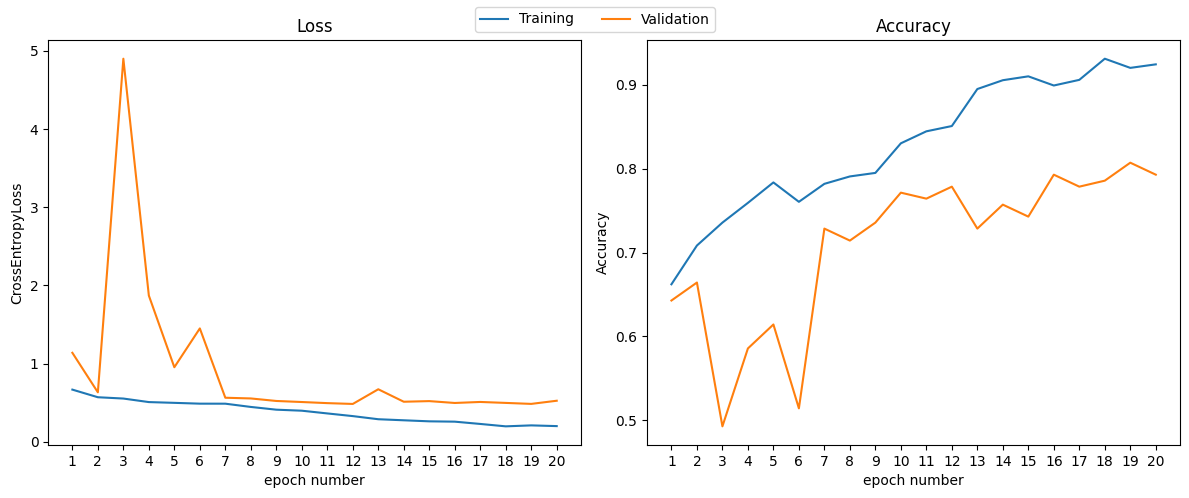

In [12]:
df = pd.read_csv(nm_model+'_stats.csv')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.setp((ax1,ax2), xticks=range(len(df['epoch number'])))
ax1.plot(df['epoch number'],df['train loss'], label='Training')
ax1.plot(df['epoch number'],df['validation loss'], label='Validation')
ax1.set_title("Loss")
ax1.set_ylabel('CrossEntropyLoss')
ax1.set_xlabel('epoch number')
plt.xticks(range(len(df['epoch number'])))
ax2.plot(df['epoch number'],df['train accuracy'])
ax2.plot(df['epoch number'],df['validation accuracy'])
ax2.set_title("shares x with main")
ax2.set_title("Accuracy")
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('epoch number')
fig.tight_layout()
fig.legend(*ax1.get_legend_handles_labels(),
            loc='upper center', ncol=4)
plt.savefig(nm_model+'_plot.jpg')

In [13]:
torch.save(model_ft.state_dict(), nm_model+'.pt')

# model_ft = model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# num_ftrs = model_ft.classifier.in_features
# model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  len(class_names)))
# model_ft.load_state_dict(torch.load('models/dens_4b_24e_17m.pt'))

torch.cuda.empty_cache()

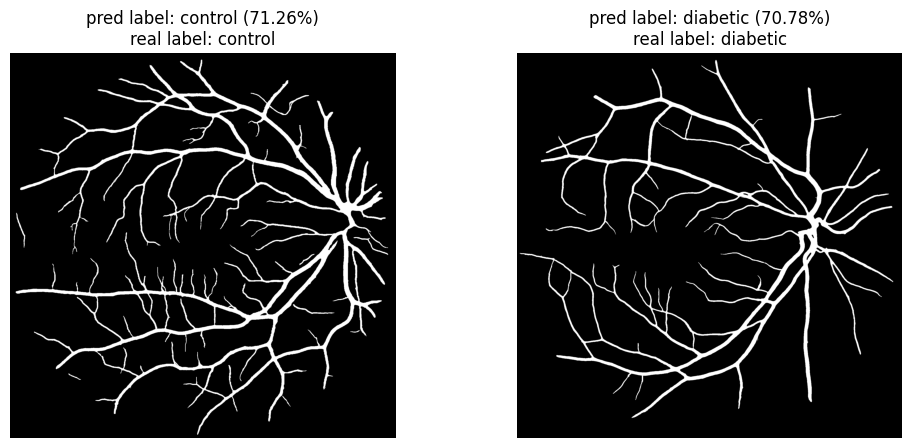

In [14]:
paths = ["data/data_m_vessel/test/control/193_N.png", "data/data_m_vessel/test/retina/81_D.png"]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, pathImageFile in enumerate(paths):
    
    if pathImageFile.split('\\')[-1].split('.')[0].split('_')[1]=='c' or pathImageFile.split('\\')[-1].split('.')[0].split('_')[-1] in ['h', 'N']:
        true_leb = 'control'
    else:
        true_leb = 'diabetic'
    
    imageData = Image.open(pathImageFile).convert('RGB')
    imageDataN = data_transforms['test'](imageData)
    imageDataN = imageDataN.unsqueeze_(0).cuda()
    output = model_ft(imageDataN)
    sm = nn.Softmax(dim=1)
    prob = round((sm(output)[0][torch.max(output,1)[1]]).item()*100,2)
    classes = ['control', 'diabetic']
    label = classes[torch.max(output,1)[1]] + ' (' + str(prob) + '%)'

    ax[i].imshow((imageData ))
    ax[i].set_title('pred label: '+label+('\nreal label: '+true_leb))
    ax[i].axis("off")
fig.savefig(nm_model+'_viz.jpg')

In [15]:
paths_list = glob('data/data_m_vessel/test/control/*') + glob('data/data_m_vessel/test/retina/*')

pvbm_data = pd.DataFrame({'image_name': [],
                          'status': [],
                          'area': [],
                          'endpoints': [],
                          'intersection_points': [],
                          'median_tortuosity': [],
                          'tortuosity_index': [],
                          'length': [],
                          'perimeter': [],
                          'BA_mean': [],
                          'BA_std': [],
                          'BA_median':[],
                          'D0':[],
                          'D1':[],
                          'D2':[],
                          'SL':[],
                          'prob_0':[],
                          'prob_1':[],
                          'pred_status':[]})

In [21]:
for i, path in enumerate(paths_list):
#for i, path in enumerate(["data/data_m_vessel/test/control/193_N.png", "data/data_m_vessel/test/retina/81_D.png"]):
    index = i+1
    
    name = path.split('\\')[-1]
    pvbm_data.at[index, 'image_name'] = name
    if name.split('.')[0].split('_')[1]=='c' or name.split('.')[0].split('_')[-1] in ['h', 'N']:
        pvbm_data.at[index, 'status'] = 0 #healthy
    else:
        pvbm_data.at[index, 'status'] = 1 #diabetic
    
    if name.split('.') == 'png':
        pixel_size = 2/2048
    else:
        if name[0] == 'a':
            pixel_size = 2/708
        else:
            pixel_size = 2/3250
        
    segmentation = Image.open(path)
    segmentation = segmentation.filter(ImageFilter.ModeFilter(size=3))
    segmentation = np.array(segmentation)/255
    if len(segmentation.shape) == 3 : segmentation = segmentation[:,:,0]
    skeleton = skeletonize(segmentation) 
    
    geometricalVBMs = GeometricalVBMs()
    a = geometricalVBMs.area(segmentation)
    pvbm_data.at[index, 'area'] = a * pixel_size * pixel_size
    
    n_end,n_inter,_,_ = geometricalVBMs.compute_particular_points(skeleton)
    pvbm_data.at[index, 'endpoints'] = n_end
    pvbm_data.at[index, 'intersection_points'] = n_inter
    
    median_tor, length,chord,arc,connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton)
    pvbm_data.at[index, 'median_tortuosity'] = median_tor
    pvbm_data.at[index, 'tortuosity_index'] = np.sum(arc)/np.sum(chord)
    pvbm_data.at[index, 'length'] = length * pixel_size
    #maybe arc and chord mean 
    
    p,_ = geometricalVBMs.compute_perimeter(segmentation)
    pvbm_data.at[index, 'perimeter'] = p *pixel_size
    
    mean_ba,std_ba,median_ba,_,_ = geometricalVBMs.compute_branching_angles(skeleton)
    pvbm_data.at[index, 'BA_mean'] = mean_ba
    pvbm_data.at[index, 'BA_std'] = std_ba
    pvbm_data.at[index, 'BA_median'] = median_ba
    
    fractalVBMs = MultifractalVBMs(n_rotations = 25,optimize = True, min_proba = 0.0001, maxproba = 0.9999)
    D0,D1,D2,SL = fractalVBMs.compute_multifractals(segmentation)
    pvbm_data.at[index, 'D0'] = D0
    pvbm_data.at[index, 'D1'] = D1
    pvbm_data.at[index, 'D2'] = D2
    pvbm_data.at[index, 'SL'] = SL
    
    imageData = Image.open(path).convert('RGB')
    imageDataN = data_transforms['test'](imageData)
    imageDataN = imageDataN.unsqueeze_(0).cuda()
    output = model_ft(imageDataN)
    sm = nn.Softmax(dim=1)
    prob = sm(output)[0]
    classes = [0, 1]
    label = classes[torch.max(output,1)[1]]
    pvbm_data.at[index, 'pred_status'] = label
    pvbm_data.at[index, 'prob_0'] = prob[0].item()
    pvbm_data.at[index, 'prob_1'] = prob[1].item()
    

In [22]:
pvbm_data.to_csv('morphological_data/morph_stats_test.csv', index=True)